# Analysis of the LLM Runs
This will use the the event_study file to analyse the performance across the different strategies. The strategies tested in this file are:

- Base case (consensus estimates from Wall Street analysts on the sellside)
- Llama (zero shot)
- Llama (chain of thought)

In [22]:
import json
import pandas as pd
import numpy as np
import importlib
import os

import event_study as es
import utils.tradegeneration as tg

from bloomberg.bquant.signal_lab.workflow.utils import get_sandbox_path
from backtest_params import get_analyst_params, get_universe_params

from prompts import SYSTEM_PROMPTS

import plotly.express as px

datapack_path = f"{get_sandbox_path()}/tmp/fs/datapack"

In [23]:
importlib.reload(es)
importlib.reload(tg)

<module 'utils.tradegeneration' from '/project/utils/tradegeneration.py'>

## Base case

This is used as the baseline and is the consensus estimates based on Wall Street sellside analysts. The recommendations are aggregated across a number of analysts. If the rating is 5, this is a strong buy, if the rating is a 1, this is a strong sell. 

In [51]:
# STEP 1: Get the data 
start = '2020-02-07'
end = '2024-12-31'
universe_name = 'INDU Index'
universe, benchmark, trading_calendar = get_universe_params(start, end, universe_name, datapack_path)
analyst_ratings = get_analyst_params(start, end, datapack_path)

In [52]:
analyst_ratings.bind_universe(universe)
ratings_df = analyst_ratings.df().ffill()

100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


In [53]:
# STEP 2: Convert the recommendations into a list of trades
def rating(rating: float) -> int:
    if rating > 3.5:
        return 1
    if rating < 3.0:
        return -1
    else:
        return 0

def trade_direction(trade: int) -> str:
    if trade == 1:
        return "BUY"
    if trade == -1:
        return "SELL"
    else:
        return "HOLD"

def convert_to_trade_view(df: pd.DataFrame) -> pd.DataFrame:
    trade_dfs = []
    # loop through each column
    for security in ratings_df.columns:
        # convert to a numerical buy/ sell/ hold
        df[security] = df[security].apply(rating)
        diff_df = df[[security]]
        diff_df['diff'] = diff_df[security].diff().fillna(1)
        # look for where the rating has changed and filter on this date
        trade_df = diff_df[diff_df['diff'] != 0]
        # change back to BUY/ SELL/ HOLD
        trade_df[security] = trade_df[security].apply(trade_direction)
        # reformat the dataframe so that it is Date | Security | trade direction
        trade_df['Security'] = security
        final_df = trade_df.reset_index().rename(columns={security:'Decision', 'DATE':'Date'})[['Date','Security', 'Decision']].reset_index()
        trade_dfs.append(final_df)
    return pd.concat(trade_dfs)

trade_analyst_recommendations = convert_to_trade_view(ratings_df.copy(deep=True))

In [54]:
# STEP 3: Backtest the strategy using the EventBacktester
backtest = es.EventBacktest(start=start, 
                            end=end, 
                            universe_name=universe_name, 
                            data_pack_path=datapack_path)
results = backtest.run(trade_analyst_recommendations, 'base')

100%|██████████| 117/117 [00:41<00:00,  2.79it/s]


In [55]:
df_strategy_return, df_benchmark_return = backtest.get_return_data()

In [56]:
df_chart = df_strategy_return.merge(df_benchmark_return, left_index=True, right_index=True).rename(columns={'Cum. Return (Gross)_x': 'Return - BASE', 'Cum. Return (Gross)_y':'Return - Benchmark'})[['Return - BASE','Return - Benchmark']]

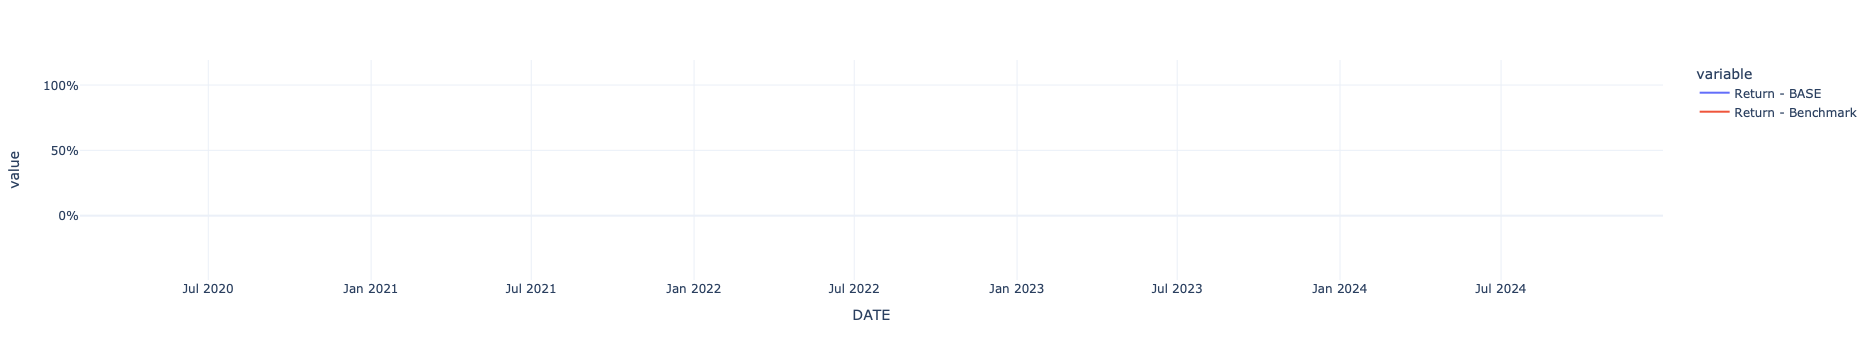

In [57]:
fig = px.line(df_chart)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

## LLM Strategies

Loop through each of the strategies in results. 

In [58]:
# STEP 1: Go through the saved results in the Results folder and generate the trade reports
def find_prompt_type(prompt):
    for prompt_type in SYSTEM_PROMPTS.keys():
        if SYSTEM_PROMPTS[prompt_type]['prompt'] == prompt:
            return prompt_type
    return None


results = {}
# Loop through all of the results 
for file in os.listdir('Results'):
    # filter out the non-json files in the folder
    if file[-5:] == '.json':
        
        with open(f'Results/{file}', 'rb') as f:
            result = json.load(f)
            # find the system prompt to add into the name
            prompt_type = find_prompt_type(result['system_prompt'])
            # store the trade report in the results dictionary
            results[f"{result['model']} - {prompt_type}"] = tg.generate_trade_report(result['results'])

In [59]:
# Example output of the trade report from the LLM
pd.DataFrame(data=results['deepseek-ai/DeepSeek-R1-Distill-Qwen-14B - CoT'])

,Date,Security,Decision,Confidence
0,2020-02-06,MMM UN Equity,HOLD,70.0
1,2020-02-12,CSCO UW Equity,BUY,85.0
2,2020-02-12,AMGN UQ Equity,BUY,75.0
3,2020-02-13,AXP UN Equity,HOLD,NaN
4,2020-02-13,NVDA UQ Equity,SELL,70.0
...,...,...,...,...
891,2025-01-31,XOM UN Equity,SELL,75.0
892,2025-02-04,PFE UN Equity,HOLD,60.0
893,2025-02-04,MRK UN Equity,HOLD,65.0
894,2025-02-04,AMGN UW Equity,HOLD,75.0


In [30]:
# Event backtest each of the results and store in the trade_results dictionary
trade_results = {}
for key in results.keys():
    trades = pd.DataFrame(results[key])
    backtest_output = backtest.run(trades,'key')
    df_strategy, df_benchmark = backtest.get_return_data()
    trade_results[key] = df_strategy

100%|██████████| 117/117 [00:41<00:00,  2.85it/s]


In [61]:
# Format the dataframes to create a single dataframe for the chart
df_baseline = df_chart.copy(deep=True)

def format_chart(trade_results, df):
    for key in trade_results.keys():
        df1 = trade_results[key][['Cum. Return (Gross)']]
        df  = df.merge(df1, left_index=True, right_index=True).rename(columns={'Cum. Return (Gross)': f'Return - {key}'})
    return df

# create a dataframe for the charts
df_charts = format_chart(trade_results, df_baseline)

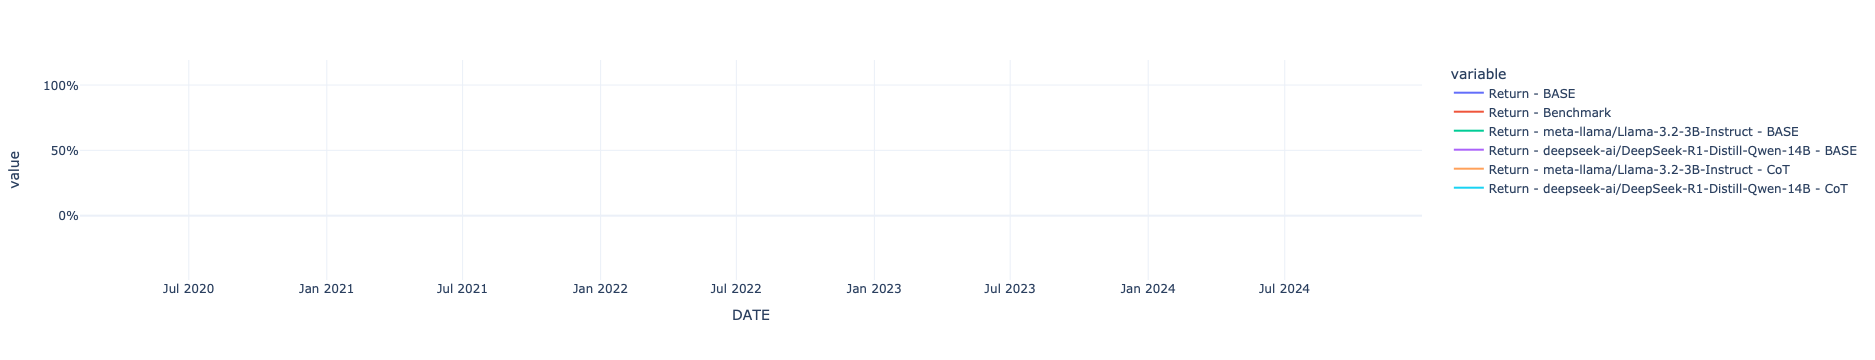

In [62]:
fig = px.line(df_charts)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

### Single Inference Strategy Analysis

In [63]:
# load the data
with open('Results/results - 2025-02-23 13:59:33.728956.json', 'rb') as file:
    base = json.load(file)
    
base['model']

'meta-llama/Llama-3.2-3B-Instruct'

In [64]:
results = base['results']

In [65]:
results[0]

{'date': '2020-02-06',
 'security': 'MMM UN Equity',
 'response': {'decision': 'BUY',
  'confidence score': 70,
  'reason': "Despite a decline in revenue, the company has shown a consistent increase in gross profit over the past few years, which indicates a potential for growth. Additionally, the company's debt-to-equity ratio is relatively low, indicating a healthy financial position. However, the stock price has been volatile in recent months, which may be a concern.",
  'AdditionalContext': "Here is the analysis of the company's financial statements:I have computed the following financial ratios:* Debt-to-Equity Ratio: 0.34 (2020-02-06)* Interest Coverage Ratio: 13.44 (2020-02-06)* Return on Equity (ROE): 14.15% (2020-02-06)* Return on Assets (ROA): 8.55% (2020-02-06)These ratios suggest that the company is in a relatively healthy financial position, but the volatile stock price and declining revenue are concerns. The decision to buy is based on the potential for growth indicated by

In [66]:
trades = tg.generate_trade_report(results)
trades_df = pd.DataFrame(data=trades)

In [68]:

def explore_data(df):
    print("Number Missing: ", df['Decision'].value_counts()['Missing'])
    print("Number of Buy: ", df['Decision'].value_counts()['BUY'])
    print("Number of Sell: ", df['Decision'].value_counts()['SELL'])
    print("Number of Hold: ", df['Decision'].value_counts()['HOLD'])

In [69]:
explore_data(trades_df)

Number Missing:  7
Number of Buy:  863
Number of Sell:  13
Number of Hold:  13
